<font size ="8"> Importing data </font>



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import imageio as iio
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import pandas as pd

In [ ]:
!wget -O data.zip https://www.dropbox.com/s/tzs174hrjs1rbzs/FashionMNIST.zip?dl=0
!unzip data.zip

--2023-01-16 12:21:56--  https://www.dropbox.com/s/tzs174hrjs1rbzs/FashionMNIST.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tzs174hrjs1rbzs/FashionMNIST.zip [following]
--2023-01-16 12:21:56--  https://www.dropbox.com/s/raw/tzs174hrjs1rbzs/FashionMNIST.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbd1a247fce07c9d8f3e9973b9c.dl-eu.dropboxusercontent.com/cd/0/inline/B0q7WThH4xXGbtAJYi5r4sKbRaUcwQg2R6OWBU8VeKtOXeskZsy2OvJgUfh73GYR-8XOS_C877UTtqpiimF0XdcC8BOuTNyaNjsx6VhXc3TeTxWwp3NtvRl7t8K6l3-1iI4CAWBEQK_fTdL6eLj42J3nhHS8eLoAwzHKxJIMryTNPg/file# [following]
--2023-01-16 12:21:56--  https://ucbd1a247fce07c9d8f3e9973b9c.dl-eu.dropboxusercontent.com/cd/0/inline/B0q7WThH4xXGbtAJYi5r4sKbRaUcwQg2R6OWBU8VeKtOXeskZsy2Ov

In [ ]:
!ls


data.zip		 sample_data		 train-images-idx3-ubyte
fashion-mnist_test.csv	 t10k-images-idx3-ubyte  train-labels-idx1-ubyte
fashion-mnist_train.csv  t10k-labels-idx1-ubyte


# DataLoader for csv

In [ ]:
class MyDataset(Dataset):
  def __init__(self,path_csv):
    super().__init__()
    # read data from path and convert to numpy ( was csv )
    self.data = pd.read_csv(path_csv).to_numpy()
    self.images = self.data[:,1:]
    self.labels = self.data[:,1]
  def __len__(self):
    # number of rows of data
    return self.data.shape[0]

  def __getitem__(self, idx):
    im = self.images[idx,:]
    label = self.labels[idx]
    # convert to images 28 * 28 , first index to be number of channels
    im = np.reshape(im,(1,28,28))/255 # to have double
    return (im,label)

In [ ]:
dataset = MyDataset("fashion-mnist_train.csv")

Text(0.5, 1.0, '0')

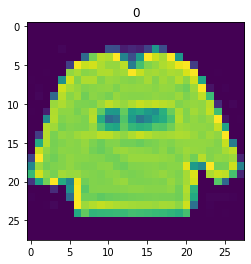

In [ ]:
plt.imshow(dataset[0][0][0,:,:])
plt.title(dataset[0][1])

#Neural Network 

In [ ]:
class AutoEncoderConv(nn.Module):
  def __init__(self, nz):
    super().__init__()
    self.nz = nz
    self.econv1 = nn.Conv2d(1, 16, 3, 1, 1)
    self.ebn1 = nn.BatchNorm2d(16)
    self.econv2 = nn.Conv2d(16, 32, 3, 2, 1)
    self.ebn2 = nn.BatchNorm2d(32)
    self.econv3 = nn.Conv2d(32, 64, 3, 2, 1)
    self.ebn3 = nn.BatchNorm2d(64)
    self.elinear1 = nn.Linear( 7*7*64, 100)
    self.ebn4 = nn.BatchNorm1d(100)
    self.elinear2 = nn.Linear(100, nz)


    self.plinear1 = nn.Linear(nz,nz)
    self.plinear2 = nn.Linear(nz,nz)

    self.dlinear1 = nn.Linear(nz, 100)
    self.dbn1 = nn.BatchNorm1d(100)
    self.dlinear2 = nn.Linear(100, 7*7*64)
    self.dbn2 = nn.BatchNorm1d(7*7*64)
    self.dconv1 = nn.ConvTranspose2d(64, 32, 3, 1, 1)
    self.dbn3 = nn.BatchNorm2d(32)
    self.dconv2 = nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding= 1)
    self.dbn4 = nn.BatchNorm2d(16)
    self.dconv3 = nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding= 1)


  def encoder_head(self, x):
    x = torch.relu(self.econv1(x))
    x = self.ebn1(x)
    x = torch.relu(self.econv2(x))
    x = self.ebn2(x)
    x = torch.relu(self.econv3(x))
    x = self.ebn3(x)
    x = x.view(-1,7*7*64)
    x = torch.relu(self.elinear1(x))
    x = self.ebn4(x)
    x = torch.sigmoid(self.elinear2(x))
    return x

  def get_params(self, x):
    mu = self.plinear1(x)
    logvar = self.plinear2(x)
    return (mu, logvar)


  def reparm(self, mu, logvar):
    eps = torch.randn(mu.shape).to(device)
    z = mu + eps* torch.exp(0.5*logvar)
    return z

    # log val =log sigma^2 = 2*log sigma--->. o.5*2*log sigma =log sigma



  def decoder(self, x):
    x = torch.relu(self.dlinear1(x))
    x = self.dbn1(x)
    x = torch.relu(self.dlinear2(x))
    x = self.dbn2(x)
    x = x.view(-1,64 ,7 ,7 )
    x = torch.relu(self.dconv1(x))
    x = self.dbn3(x)
    x = torch.relu(self.dconv2(x))
    x = self.dbn4(x)
    x = torch.sigmoid(self.dconv3(x))
    return x


  def forward(self,x):
    x = self.encoder_head(x)
    mu, logvar = self.get_params(x)
    z = self.reparm(mu, logvar)
    x = self.decoder(z)
    return (z, mu, logvar, x)




In [ ]:
def vae_loss(xhat, x, mu, logvar):
  KL_WEIGHT = 0.00012
  recon_loss = F.mse_loss(xhat, x)
  kl_loss = torch.mean(torch.sum(-0.5*(1+logvar - torch.exp(logvar) - mu*mu), axis =1), axis =0)
  return (1-KL_WEIGHT)*recon_loss + (KL_WEIGHT)*kl_loss

In [ ]:

train_loader = DataLoader(dataset,batch_size = 64)


#Train

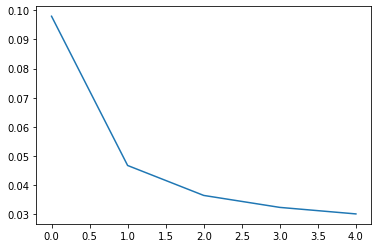

In [ ]:
device = torch.device("cuda:0")
ni = 28*28
nh = 300
nz = 32
net = AutoEncoderConv(nz).to(device)
num_epochs = 5
lr = 1e-4
mm = 0.5

optimizer = optim.Adam(net.parameters(), lr = lr)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X = batch[0].type(torch.FloatTensor).to(device)
    Z, mu, logvar, Xhat = net(X)
    loss = vae_loss(Xhat, X, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss+=loss.item()


  ls.append(total_loss/len(train_loader))


plt.plot(ls)



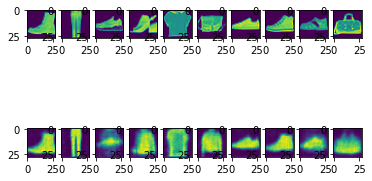

In [ ]:
for i in range(10):
  plt.subplot(2, 10, i+1)
  plt.imshow(X.cpu()[i,0,:,:])
  plt.subplot(2,10,i+11)
  plt.imshow(Xhat[i,0,:,:].detach().cpu().numpy())

In [ ]:
with torch.no_grad():
  net.eval()
  z = torch.randn(10, nz).to(device)

  Xgen = net.decoder(z)

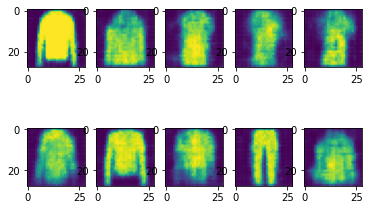

In [ ]:
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(Xgen.cpu().numpy()[i,0,:,:])